**NAME: PARTHA SAKHA PAUL**

**ROLL: MA23M016**

    CS6910_assignment1

In [152]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# importing dataset
from keras.datasets import fashion_mnist

# ***Question 1***

Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use from keras.datasets import fashion_mnist for getting the fashion mnist dataset.

In [153]:
# loading the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# spliting data for validation
x_val = x_train[54000:]
y_val = y_train[54000:]
# print(x_val)
# print(y_val)
# spliting data for training
x_train = x_train[:54000]
y_train = y_train[:54000]
# print(x_train)
# print(y_train)

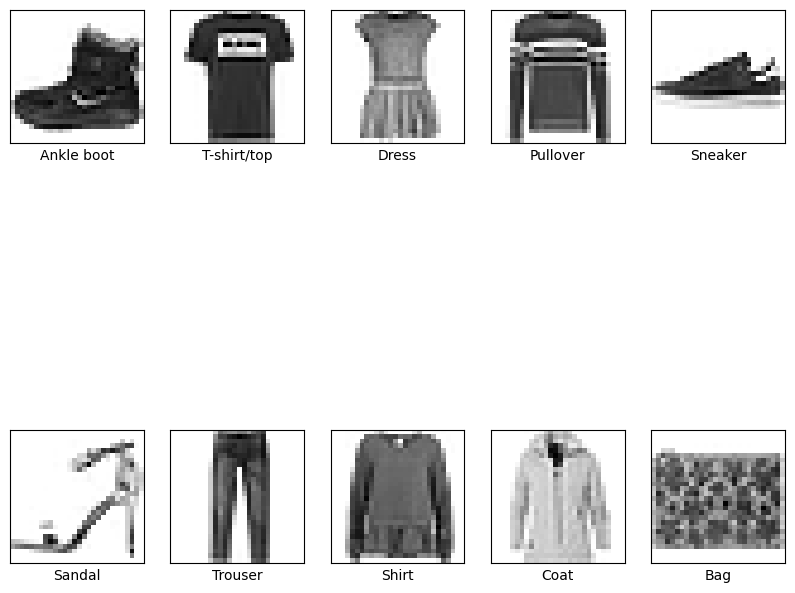

In [154]:
# labels
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
image = []
label = []
for i in range(54000):
  if len(label) >= 10:
    break;
  if class_names[y_train[i]] not in label:
      image.append(x_train[i])
      label.append(class_names[y_train[i]])

#the dimensions of the plot grid
plt.figure(figsize=(10,10))

for i in range(len(image)):
  plt.subplot(2, 5, i+1)  #plotting in a 2x5 grid
  plt.xticks([])  #remove x-ticks
  plt.yticks([])  #remove y-ticks
  plt.grid(False)  #no grid
  plt.imshow(image[i], cmap=plt.cm.binary)  #plotting the image in binary colormap
  plt.xlabel(label[i])  #x-axis label
plt.show()

In [155]:
# vectorise the data
x_train = x_train.reshape(x_train.shape[0], 784)
# print(x_train.shape)
x_val  = x_val.reshape(x_val.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# normalize
x_train = x_train / 255.0
x_test = x_test / 255.0
x_val  = x_val / 255.0
# print(x_train)

# One hot encoding for labels
def one_hot_enc(labels, dimension=10):
    # Creating an array of zeros of shape (number of labels, number of categories)
    one_hot_labels = np.zeros((len(labels), dimension))

    one_hot_labels[np.arange(len(labels)), labels] = 1
    return one_hot_labels

print(y_train[1023])
# one-hot encoding to the datasets
y_train_encode = one_hot_enc(y_train)
y_val_encode = one_hot_enc(y_val)
y_test_encode = one_hot_enc(y_test)

print(y_train_encode[1023])  # for verifying
print(y_train_encode.shape) #verifying

7
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(54000, 10)


In [156]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def sigmoid_deriv(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def relu(x):
    return np.maximum(0, x)

def relu_deriv(x):
    return np.where(x <= 0, 0, 1)

def tanh(x):
    return np.tanh(x)

def tanh_deriv(x):
    return 1 - np.tanh(x)**2

def cross_entropy(y_hat, y, sum_norm, regpara):
    m = y.shape[0]
    logyhat = np.log(y_hat)
    loss = -np.sum(y * logyhat) / m + regpara / 2 * sum_norm
    return loss

activation_functions = {
    "sigmoid": sigmoid,
    "relu": relu,
    "tanh": tanh
}

activation_derivatives = {
    "sigmoid": sigmoid_deriv,
    "relu": relu_deriv,
    "tanh": tanh_deriv
}


# ***Question 2***
Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

In [157]:
class NeuralNetwork:
    def __init__(self, layer_sizes, activation_func="sigmoid", weight_init="random"):
        self.layer_sizes = layer_sizes
        self.activation_func = activation_func
        self.weights, self.biases = self.init_network(layer_sizes, weight_init)
        self.momenta_weights, self.momenta_biases = self.init_momenta_for_mgd()


    def init_network(self, layer_sizes, weight_init):
        weights = []
        biases = []
        # i = 0 to L-1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(len(layer_sizes) - 1):
            # "xavier" weight_initialization
            if weight_init == "xavier":
                stddev = np.sqrt(2 / (layer_sizes[i] + layer_sizes[i + 1]))
            #random initialization
            else:
                stddev = 0.1  # standard deviation for random initialization

            weight = np.random.randn(layer_sizes[i], layer_sizes[i + 1]) * stddev
            bias = np.zeros((1, layer_sizes[i + 1]))
            weights.append(weight)
            biases.append(bias)
        return weights, biases

    def init_momenta_for_mgd(self):
        momenta_weights = []
        momenta_biases = []
        for i in range(len(self.layer_sizes) - 1):
            v_weight = np.zeros((self.layer_sizes[i], self.layer_sizes[i + 1]))
            v_bias = np.zeros((1, self.layer_sizes[i + 1]))
            momenta_weights.append(v_weight)
            momenta_biases.append(v_bias)
        return momenta_weights, momenta_biases


    def feedforward(self, X):
        a = {}
        h = {"h0": X}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            h_previous = h["h" + str(i-1)]   #input layer(data point)
            a_current = np.dot(h_previous, self.weights[i-1]) + self.biases[i-1]
            a["a" + str(i)] = a_current
            if i == len(self.layer_sizes) - 1:  # for output layer
                h_current = softmax(a_current)
            else:
                h_current = activation_functions[self.activation_func](a_current)   #sigmoid(a_current)
            h["h" + str(i)] = h_current
        y_hat = h["h" + str(len(self.layer_sizes) - 1)]
        return h, a, y_hat


In [158]:
layer_sizes = [784, 128, 10]

# initializing the model
model_forward = NeuralNetwork(layer_sizes, activation_func="sigmoid", weight_init="random")
_,_,y_hat = model_forward.feedforward(x_train)
print('A probability distribution over the 10 classes by feedforward NN before train:: \n',y_hat[5180])
# print(sum(y_hat[51]))
print('Corresponding labelled output:: \n',y_train_encode[5180])

A probability distribution over the 10 classes by feedforward NN before train:: 
 [0.12884147 0.0659087  0.19163182 0.10808572 0.04337185 0.11638626
 0.06621584 0.04796008 0.02830506 0.20329319]
Corresponding labelled output:: 
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


# ***Question 3***
Implement the backpropagation algorithm with support for the following optimisation functions

    sgd
    momentum based gradient descent
    nesterov accelerated gradient descent
    rmsprop
    adam
    nadam

In [162]:
# for backward propagation and the optimizers
class backward_optimizer(NeuralNetwork):
    def backward(self, h, a, y, y_hat):
        number_hidden = len(self.layer_sizes) - 2  #excluding input and output layers
        grad = self.init_grad()

        #derivative of cross-entropy w.r.t softmax function
        da = y_hat - y

        # i = L to 1; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in reversed(range(1, len(self.layer_sizes))):
            grad["dW" + str(i)] = np.dot(h["h" + str(i-1)].T, da) / y.shape[0]   #for normalizing, dividing by y.shape[0]
            grad["db" + str(i)] = np.sum(da, axis=0, keepdims=True) / y.shape[0]
            if i > 1:  #no need to calculate derivatives after the first hidden layer
                dh_previous = np.dot(da, self.weights[i-1].T)
                da = dh_previous * activation_derivatives[self.activation_func](a["a" + str(i-1)])
        return grad

    def init_grad(self):
        grad = {}
        # i = 1 to L; here len(self.layer_sizes) = L+1(input_layer+hidden_layers+output_layer)
        for i in range(1, len(self.layer_sizes)):
            grad["dW" + str(i)] = np.zeros_like(self.weights[i-1])   #initializing dw1 with W1 having all zeros
            grad["db" + str(i)] = np.zeros_like(self.biases[i-1])    #initializing db1 with b1 having all zeros
        return grad

    def vanilla_gd(self, grads, eta):
        # i = 0 to L-1; here len(self.weights) = L (as weights = [W1,W2,W3,...], list of weights W1,W2,W3,....)
        for i in range(len(self.weights)):
            self.weights[i] -= eta * grads["dW" + str(i + 1)]   #updating W1,W2,W3 by grad_descent rule
            self.biases[i] -= eta * grads["db" + str(i + 1)]    #updating b1,b2,b3 by grad_descent rule

    def sgd(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara):
        train_datapoints = X_train.shape[0]  #train_datapoints = 54000

        for epoch in range(max_epochs):
            for start in range(0, train_datapoints, batch_size):
                end = min(start + batch_size, train_datapoints)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                # Forward prop
                h, a, y_hat = self.feedforward(X_batch)
                # print(h['h0'])

                # Backward prop
                grad = self.backward(h, a, Y_batch, y_hat)

                # Update weights and biases with SGD
                for i in range(1, len(self.layer_sizes)):
                    self.weights[i-1] -= eta * (grad["dW" + str(i)] + regpara * self.weights[i-1])
                    self.biases[i-1] -= eta * grad["db" + str(i)]

            # printing loss and accuracy at the end of each epoch
            loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
            print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
            # wandb.log({'train_loss': loss})
            # wandb.log({'train_accuracy': accuracy*100 })
            # wandb.log({'epoch': epoch + 1})

            # printing loss and accuracy on the validation dataset
            val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
            print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
            # wandb.log({'val_loss': val_loss})
            # wandb.log({'val_accuracy': val_accuracy*100 })

    def mgd(self,X_train, Y_train, X_val, Y_val_encode, max_epochs, eta, batch_size, regpara,beta=0.9):
        train_datapoints = X_train.shape[0]  #train_datapoints = 54000

        for epoch in range(max_epochs):
            for start in range(0, train_datapoints, batch_size):
                end = min(start + batch_size, train_datapoints)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                # Forward prop
                h, a, y_hat = self.feedforward(X_batch)

                # Backward prop
                grad = self.backward(h, a, Y_batch, y_hat)

                # update with momentum
                for i in range(len(self.weights)):
                    # momentum updates
                    self.momenta_weights[i] = beta * self.momenta_weights[i] + eta * grad["dW" + str(i + 1)]
                    self.momenta_biases[i] = beta * self.momenta_biases[i] + eta * grad["db" + str(i + 1)]

                    # update weights and biases
                    self.weights[i] -= self.momenta_weights[i]
                    self.biases[i] -= self.momenta_biases[i]

            # printing loss and accuracy at the end of each epoch
            loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
            print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
            # wandb.log({'train_loss': loss})
            # wandb.log({'train_accuracy': accuracy*100 })
            # wandb.log({'epoch': epoch + 1})

            # printing loss and accuracy on the validation dataset
            val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
            print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
            # wandb.log({'val_loss': val_loss})
            # wandb.log({'val_accuracy': val_accuracy*100 })


    def nag(self, X_train, Y_train, X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta=0.9):
        train_datapoints = X_train.shape[0]

        # initializing momenta for NAG
        prev_momenta_weights = [np.zeros_like(w) for w in self.weights]
        prev_momenta_biases = [np.zeros_like(b) for b in self.biases]

        for epoch in range(max_epochs):
            for start in range(0, train_datapoints, batch_size):
                end = min(start + batch_size, train_datapoints)
                X_batch = X_train[start:end]
                Y_batch = Y_train[start:end]

                # storing original weights and biases
                original_weights = [np.copy(w) for w in self.weights]
                original_biases = [np.copy(b) for b in self.biases]

                #  NAG method
                self.weights = [w - beta * v for w, v in zip(self.weights, prev_momenta_weights)]
                self.biases = [b - beta * v for b, v in zip(self.biases, prev_momenta_biases)]

                # Forward prop with lookahead weights and biases
                h, a, y_hat = self.feedforward(X_batch)

                # Backward prop
                grads = self.backward(h, a, Y_batch, y_hat)

                # Taking original weights and biases before actual update
                self.weights = original_weights
                self.biases = original_biases

                # Updating with computed grads and momentums
                for i in range(len(self.weights)):
                    momenta_weights = beta * prev_momenta_weights[i] + eta * grads["dW" + str(i + 1)]
                    momenta_biases = beta * prev_momenta_biases[i] + eta * grads["db" + str(i + 1)]

                    self.weights[i] -= momenta_weights
                    self.biases[i] -= momenta_biases

                    # Updating momenta for next iteration
                    prev_momenta_weights[i] = momenta_weights
                    prev_momenta_biases[i] = momenta_biases

            # printing loss and accuracy at the end of each epoch
            loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
            print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
            # wandb.log({'train_loss': loss})
            # wandb.log({'train_accuracy': accuracy*100 })
            # wandb.log({'epoch': epoch + 1})

            # printing loss and accuracy on the validation dataset
            val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
            print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
            # wandb.log({'val_loss': val_loss})
            # wandb.log({'val_accuracy': val_accuracy*100 })

    def rmsprop(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta=0.9, epsilon=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing square gradients
      s_weights = [np.zeros_like(w) for w in self.weights]
      s_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat)

              # updating weights and biases with RMSprop
              for i in range(len(self.weights)):
                  # updating square gradients
                  s_weights[i] = beta * s_weights[i] + (1 - beta) * np.square(grads["dW" + str(i + 1)])
                  s_biases[i] = beta * s_biases[i] + (1 - beta) * np.square(grads["db" + str(i + 1)])

                  # updating weights and biases
                  self.weights[i] -= eta * grads["dW" + str(i + 1)] / (np.sqrt(s_weights[i]) + epsilon)
                  self.biases[i] -= eta * grads["db" + str(i + 1)] / (np.sqrt(s_biases[i]) + epsilon)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
          # wandb.log({'train_loss': loss})
          # wandb.log({'train_accuracy': accuracy*100 })
          # wandb.log({'epoch': epoch + 1})

          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
          # wandb.log({'val_loss': val_loss})
          # wandb.log({'val_accuracy': val_accuracy*100 })


    def adam(self, X_train, Y_train,X_val, Y_val_encode, max_epochs, eta, batch_size, regpara, beta1=0.9, beta2=0.999, eps=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing momenta (m) and velocities (v) for Adam
      m_weights = [np.zeros_like(w) for w in self.weights]
      m_biases = [np.zeros_like(b) for b in self.biases]
      v_weights = [np.zeros_like(w) for w in self.weights]
      v_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat)

              # Adam updates for each layer
              for i in range(len(self.weights)):
                  # updating momenta and velocities
                  m_weights[i] = beta1 * m_weights[i] + (1 - beta1) * grads["dW" + str(i + 1)]
                  m_biases[i] = beta1 * m_biases[i] + (1 - beta1) * grads["db" + str(i + 1)]
                  v_weights[i] = beta2 * v_weights[i] + (1 - beta2) * (grads["dW" + str(i + 1)] ** 2)
                  v_biases[i] = beta2 * v_biases[i] + (1 - beta2) * (grads["db" + str(i + 1)] ** 2)

                  # modified momenta and velocities
                  m_hat_weights = m_weights[i] / (1 - beta1 ** (epoch + 1))
                  m_hat_biases = m_biases[i] / (1 - beta1 ** (epoch + 1))
                  v_hat_weights = v_weights[i] / (1 - beta2 ** (epoch + 1))
                  v_hat_biases = v_biases[i] / (1 - beta2 ** (epoch + 1))

                  # updating weights and biases
                  self.weights[i] -= eta * m_hat_weights / (np.sqrt(v_hat_weights) + eps)
                  self.biases[i] -= eta * m_hat_biases / (np.sqrt(v_hat_biases) + eps)

          # print loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
          # wandb.log({'train_accuracy': accuracy*100 })
          # wandb.log({'train_loss': loss})
          # wandb.log({'epoch': epoch + 1})

          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
          # wandb.log({'val_accuracy': val_accuracy*100 })
          # wandb.log({'val_loss': val_loss})


    def nadam(self, X_train, Y_train,X_val, Y_val_encode, max_epochs=5, eta=0.001, batch_size=16, regpara=0, beta1=0.9, beta2=0.999, eps=1e-8):
      train_datapoints = X_train.shape[0]

      # initializing momenta (m) and velocities (v) for NAdam
      m_weights = [np.zeros_like(w) for w in self.weights]
      m_biases = [np.zeros_like(b) for b in self.biases]
      v_weights = [np.zeros_like(w) for w in self.weights]
      v_biases = [np.zeros_like(b) for b in self.biases]

      for epoch in range(max_epochs):
          for start in range(0, train_datapoints, batch_size):
              end = min(start + batch_size, train_datapoints)
              X_batch = X_train[start:end]
              Y_batch = Y_train[start:end]

              # Forward prop
              h, a, y_hat = self.feedforward(X_batch)

              # Backward prop
              grads = self.backward(h, a, Y_batch, y_hat)

              # NAdam updates for each layer
              for i in range(len(self.weights)):
                  # update momenta and velocities
                  m_weights[i] = beta1 * m_weights[i] + (1 - beta1) * grads["dW" + str(i + 1)]
                  m_biases[i] = beta1 * m_biases[i] + (1 - beta1) * grads["db" + str(i + 1)]
                  v_weights[i] = beta2 * v_weights[i] + (1 - beta2) * (grads["dW" + str(i + 1)] ** 2)
                  v_biases[i] = beta2 * v_biases[i] + (1 - beta2) * (grads["db" + str(i + 1)] ** 2)

                  # modified momenta and velocities
                  m_hat_weights = m_weights[i] / (1 - beta1 ** (epoch + 1))
                  m_hat_biases = m_biases[i] / (1 - beta1 ** (epoch + 1))
                  v_hat_weights = v_weights[i] / (1 - beta2 ** (epoch + 1))
                  v_hat_biases = v_biases[i] / (1 - beta2 ** (epoch + 1))

                  # NAG rule
                  m_bar_weights = beta1 * m_hat_weights + ((1 - beta1) * grads["dW" + str(i + 1)]) / (1 - beta1 ** (epoch + 1))
                  m_bar_biases = beta1 * m_hat_biases + ((1 - beta1) * grads["db" + str(i + 1)]) / (1 - beta1 ** (epoch + 1))

                  # updating weights and biases
                  self.weights[i] -= eta * m_bar_weights / (np.sqrt(v_hat_weights) + eps)
                  self.biases[i] -= eta * m_bar_biases / (np.sqrt(v_hat_biases) + eps)

          # printing loss and accuracy at the end of each epoch
          loss, accuracy = self.loss_accuracy(X_train, Y_train, regpara)
          print(f"End of Epoch {epoch}, Loss: {loss}, Accuracy: {accuracy}")
          # wandb.log({'train_loss': loss})
          # wandb.log({'train_accuracy': accuracy*100 })
          # wandb.log({'epoch': epoch + 1})

          # printing loss and accuracy on the validation dataset
          val_loss, val_accuracy = self.loss_accuracy(X_val, Y_val_encode, regpara)
          print(f"End of Epoch {epoch}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")
          # wandb.log({'val_loss': val_loss})
          # wandb.log({'val_accuracy': val_accuracy*100 })



    def loss_accuracy(self, X, y, regpara=0.0):
        #for regularization when we need
        sum_norm = 0
        for weight in self.weights:   #weights = [W1,W2,W3,......]
            sum_norm += np.sum(np.square(weight))

        h, a, y_hat = self.feedforward(X)
        loss = cross_entropy(y_hat, y, sum_norm, regpara)

        predictions = np.argmax(y_hat, axis=1)   #finding indices of max element in each row of y_hat
        labels = np.argmax(y, axis=1)            #finding indices of max element in each row of y
        accuracy = np.mean(predictions == labels) #mean of the above two

        return loss, accuracy


In [163]:
layer_sizes = [784, 128, 64, 10]

# initializing the model
model = backward_optimizer(layer_sizes, activation_func="tanh", weight_init="xeiver")

#for verifying the results
# print(model.weights[0].shape)
# print(model.weights[1].shape)
# print(model.weights[0][5])
# print(model.weights[1][99])
# print()
# print(model.biases[0].shape)
# print(model.biases[1].shape)
# print(model.biases[0][0])
# print(model.biases[1][0])

In [100]:
# x_train, y_train_encode are training data and labels
#sgd
model.sgd(x_train, y_train_encode,x_val,y_val_encode, eta=0.001, max_epochs=6, batch_size=16, regpara=0)

End of Epoch 0, Loss: 1.0342592630196448, Accuracy: 0.6927037037037037
End of Epoch 0, Validation Loss: 1.0257335956314457, Validation Accuracy: 0.6981666666666667
End of Epoch 1, Loss: 0.7960398550451887, Accuracy: 0.7444444444444445
End of Epoch 1, Validation Loss: 0.7861831906461259, Validation Accuracy: 0.748
End of Epoch 2, Loss: 0.6918456691126214, Accuracy: 0.7681111111111111
End of Epoch 2, Validation Loss: 0.6844097843365022, Validation Accuracy: 0.7695
End of Epoch 3, Loss: 0.6310956271375291, Accuracy: 0.7838148148148149
End of Epoch 3, Validation Loss: 0.6263209745844036, Validation Accuracy: 0.7823333333333333
End of Epoch 4, Loss: 0.5901631937254725, Accuracy: 0.7958333333333333
End of Epoch 4, Validation Loss: 0.5876580750640282, Validation Accuracy: 0.7923333333333333
End of Epoch 5, Loss: 0.5603246121400095, Accuracy: 0.8045
End of Epoch 5, Validation Loss: 0.5596741126720303, Validation Accuracy: 0.8011666666666667


In [101]:
#mgd
model.mgd(x_train, y_train_encode, x_val,y_val_encode, eta=0.1, beta=0.9, max_epochs=11, batch_size=64, regpara=0)

End of Epoch 0, Loss: 0.4317224049692742, Accuracy: 0.8373703703703703
End of Epoch 0, Validation Loss: 0.45258376281221385, Validation Accuracy: 0.8311666666666667
End of Epoch 1, Loss: 0.4282253526785848, Accuracy: 0.8453148148148149
End of Epoch 1, Validation Loss: 0.45167811014932785, Validation Accuracy: 0.8343333333333334
End of Epoch 2, Loss: 0.4547812777037418, Accuracy: 0.8360925925925926
End of Epoch 2, Validation Loss: 0.48057320308529855, Validation Accuracy: 0.8253333333333334
End of Epoch 3, Loss: 0.44237952952164405, Accuracy: 0.8521666666666666
End of Epoch 3, Validation Loss: 0.47683564474447804, Validation Accuracy: 0.8365
End of Epoch 4, Loss: 0.4136345780035934, Accuracy: 0.8531481481481481
End of Epoch 4, Validation Loss: 0.4451536053099221, Validation Accuracy: 0.8386666666666667
End of Epoch 5, Loss: 0.38609000952841993, Accuracy: 0.858574074074074
End of Epoch 5, Validation Loss: 0.4190096321497696, Validation Accuracy: 0.8483333333333334
End of Epoch 6, Loss: 0

In [104]:
#nag
model.nag(x_train, y_train_encode,x_val,y_val_encode,  eta=0.1, beta=0.9, max_epochs=11, batch_size=64, regpara=0)

End of Epoch 0, Loss: 0.4103547778468685, Accuracy: 0.8467962962962963
End of Epoch 0, Validation Loss: 0.436451247003777, Validation Accuracy: 0.8376666666666667
End of Epoch 1, Loss: 0.38735993743471087, Accuracy: 0.8566296296296296
End of Epoch 1, Validation Loss: 0.414439031782692, Validation Accuracy: 0.8475
End of Epoch 2, Loss: 0.38778494401247743, Accuracy: 0.8533333333333334
End of Epoch 2, Validation Loss: 0.4324840752539143, Validation Accuracy: 0.841
End of Epoch 3, Loss: 0.4049541246452592, Accuracy: 0.8492777777777778
End of Epoch 3, Validation Loss: 0.4381782539742686, Validation Accuracy: 0.8353333333333334
End of Epoch 4, Loss: 0.39048526804811134, Accuracy: 0.8544814814814815
End of Epoch 4, Validation Loss: 0.4423148199321028, Validation Accuracy: 0.8395
End of Epoch 5, Loss: 0.37339018083207687, Accuracy: 0.864537037037037
End of Epoch 5, Validation Loss: 0.41766096093622845, Validation Accuracy: 0.8506666666666667
End of Epoch 6, Loss: 0.4306193940440966, Accuracy:

In [105]:
#rmsprop
model.rmsprop(x_train, y_train_encode,x_val,y_val_encode, eta=0.001, beta=0.9, max_epochs=11, batch_size=64, regpara=0.00, epsilon=1e-8)

End of Epoch 0, Loss: 0.3090382167040861, Accuracy: 0.8874814814814814
End of Epoch 0, Validation Loss: 0.36941710956386775, Validation Accuracy: 0.8716666666666667
End of Epoch 1, Loss: 0.29451417342525, Accuracy: 0.8920370370370371
End of Epoch 1, Validation Loss: 0.357456379865134, Validation Accuracy: 0.8723333333333333
End of Epoch 2, Loss: 0.2840782873845581, Accuracy: 0.8974444444444445
End of Epoch 2, Validation Loss: 0.35444313925515836, Validation Accuracy: 0.877
End of Epoch 3, Loss: 0.28064745695394633, Accuracy: 0.897962962962963
End of Epoch 3, Validation Loss: 0.35815269269904204, Validation Accuracy: 0.8741666666666666
End of Epoch 4, Loss: 0.2664202079489842, Accuracy: 0.9024444444444445
End of Epoch 4, Validation Loss: 0.350251392051385, Validation Accuracy: 0.8776666666666667
End of Epoch 5, Loss: 0.260678568819971, Accuracy: 0.9047222222222222
End of Epoch 5, Validation Loss: 0.3533901559466714, Validation Accuracy: 0.8793333333333333
End of Epoch 6, Loss: 0.2521572

In [164]:
#adam
model.adam(x_train, y_train_encode,x_val,y_val_encode, eta=0.001, beta1=0.9, beta2=0.999, max_epochs=11, batch_size=16, regpara=0.00, eps=1e-8)

End of Epoch 0, Loss: 0.3731516713897054, Accuracy: 0.865537037037037
End of Epoch 0, Validation Loss: 0.39121842321100964, Validation Accuracy: 0.856
End of Epoch 1, Loss: 0.33179312617421597, Accuracy: 0.8800740740740741
End of Epoch 1, Validation Loss: 0.3581934320802164, Validation Accuracy: 0.8691666666666666
End of Epoch 2, Loss: 0.30763268452484244, Accuracy: 0.8888148148148148
End of Epoch 2, Validation Loss: 0.34202973936834463, Validation Accuracy: 0.8741666666666666
End of Epoch 3, Loss: 0.2906050175160047, Accuracy: 0.8957037037037037
End of Epoch 3, Validation Loss: 0.33208185415212466, Validation Accuracy: 0.878
End of Epoch 4, Loss: 0.27742371050921816, Accuracy: 0.9002962962962963
End of Epoch 4, Validation Loss: 0.32537565275722885, Validation Accuracy: 0.8788333333333334
End of Epoch 5, Loss: 0.26664042823513323, Accuracy: 0.9039259259259259
End of Epoch 5, Validation Loss: 0.3206667237736713, Validation Accuracy: 0.8813333333333333
End of Epoch 6, Loss: 0.25737953345

In [165]:
#nadam
model.nadam(x_train, y_train_encode,x_val,y_val_encode, eta=0.001, beta1=0.9, beta2=0.999, max_epochs=6, batch_size=16, regpara=0.00, eps=1e-8)

End of Epoch 0, Loss: 0.2355736128645385, Accuracy: 0.9146111111111112
End of Epoch 0, Validation Loss: 0.32331990284045875, Validation Accuracy: 0.8833333333333333
End of Epoch 1, Loss: 0.22062054191449953, Accuracy: 0.9200185185185186
End of Epoch 1, Validation Loss: 0.3169677982234993, Validation Accuracy: 0.8866666666666667
End of Epoch 2, Loss: 0.21141507778401225, Accuracy: 0.9235
End of Epoch 2, Validation Loss: 0.31523844277323476, Validation Accuracy: 0.8875
End of Epoch 3, Loss: 0.20429154753588397, Accuracy: 0.9258148148148149
End of Epoch 3, Validation Loss: 0.3151010695665785, Validation Accuracy: 0.8888333333333334
End of Epoch 4, Loss: 0.19824018371779284, Accuracy: 0.928
End of Epoch 4, Validation Loss: 0.3156664458197417, Validation Accuracy: 0.8885
End of Epoch 5, Loss: 0.19285594613780271, Accuracy: 0.930074074074074
End of Epoch 5, Validation Loss: 0.3166395547375865, Validation Accuracy: 0.8886666666666667


# ***Question 4***
    Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use (X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()). Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.

    number of epochs: 5, 10
    number of hidden layers: 3, 4, 5
    size of every hidden layer: 32, 64, 128
    weight decay (L2 regularisation): 0, 0.0005, 0.5
    learning rate: 1e-3, 1 e-4
    optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
    batch size: 16, 32, 64
    weight initialisation: random, Xavier
    activation functions: sigmoid, tanh, ReLU
    wandb will automatically generate the following plots. Paste these plots below using the "Add Panel to Report" feature. Make sure you use meaningful names for each sweep (e.g. hl_3_bs_16_ac_tanh to indicate that there were 3 hidden layers, batch size was 16 and activation function was ReLU) instead of using the default names (whole-sweep, kind-sweep) given by wandb.

In [166]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.5/263.5 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


In [167]:
import wandb
import numpy as np
from types import SimpleNamespace
import random

In [168]:
wandb.login(key='25c2257eaf6c22aa056893db14da4ee2bf0a531a')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [170]:
sweep_config = {
    'method': 'grid',
    'name' : 'sweep cross entropy class change',
    'metric': {
      'name': 'train_accuracy',
      'goal': 'maximize'
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'hidden_layers':{
            'values':[3,4,5]
        },
         'hidden_size':{
            'values':[32,64,128]
        },
        'weight_decay':{
            'values':[0, 0.0005, 0.5]
        },
        'learning_rate': {
            'values': [1e-3, 1e-4]
        },
        'optimizer': {
            'values': ['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam', 'nadam']
        },
        'batch_size':{
            'values':[16,32,64]
        },
        'weight_init': {
            'values': ['xavier','random']
        },
        'activation': {
            'values': ['relu','sigmoid','tanh']
        },
    }
}

sweep_id = wandb.sweep(sweep=sweep_config, project='Deep_leraning_A1')

Create sweep with ID: 973c41y7
Sweep URL: https://wandb.ai/parthasakhapaul/Deep_leraning_A1/sweeps/973c41y7


In [171]:
def main():


    with wandb.init() as run:

        run_name="-ac_"+wandb.config.activation+"-hs_"+str(wandb.config.hidden_size)+"-epc_"+str(wandb.config.epochs)+"-hl_"+str(wandb.config.hidden_layers)+"-wd_"+str(wandb.config.weight_decay)+"-lr_"+str(wandb.config.learning_rate)+"-opt_"+wandb.config.optimizer+"-bs_"+str(wandb.config.batch_size)+"-wi_"+wandb.config.weight_init
        wandb.run.name=run_name
        model = backward_optimizer(layer_sizes=[784,wandb.config.hidden_layers,10], activation_func=wandb.config.activation, weight_init=wandb.config.weight_init)
        model.train(wandb.config.optimizer,wandb.config.epochs,wandb.config.learning_rate,batch_size = wandb.config.batch_size,regpara = wandb.config.weight_decay)



wandb.agent(sweep_id, function=main,count=1000) # calls main function for count number of times.
wandb.finish()